# Project 3: Mean, Lean, and Trendy: A Market Strategy That Does Both

## Executive Summary

### Objective

This project develops a monthly rebalanced investment strategy using the 49 Fama-French industry portfolios, aiming to maximize the portfolio’s performance. The strategy **combines momentum (long/short) and mean reversion (long-only) signals**, which are derived from past performance and used to determine portfolio weights. The strategy is backtested on the full sample and also evaluated on a randomly selected five-year period to assess robustness across time. **Performance** is measured using **annualized Sharpe ratios and cumulative total returns.**

### Strategy Design and Construction

#### Strategy A: Mean Reversion

This strategy applies a **long-only mean reversion approach**, using **60-month cumulative returns** to identify extremes. Each month, industries in the **bottom 20th percentile** are flagged as **undervalued and receive increased weight**, while those in the **top 90th percentile have their weights trimmed**. Reallocation is capped at 30% monthly, and redistributed capital is assigned inversely to return ranks, giving the most weight to the lowest-returning industries.

#### Strategy B: Momentum

This momentum-based long-short strategy where for each month, it calculates **12-month returns, skipping the most recent month** to avoid short-term reversal effects. The strategy **longs the top 15 industries and shorts the bottom 15, based on total return** rankings. It targets **130% long and 30% short exposure**, rescaling each leg independently to maintain this gross exposure. Portfolio returns are computed using the next month's performance, and only industries with available return data are included.

#### Blended Strategy

Overall, **Momentum demonstrated stronger consistency and risk-adjusted performance, while the downside risk in Mean Reversion suggests a need for regime filters or a blended approach with other strategies.** To adapt the strategy to changing market conditions, a 12-month rolling return on the market return is used to define regimes: returns above 10% signal a Bull market, below -10% indicate a Bear market, and all else are labeled Neutral. Momentum and mean reversion strategies are negatively correlated, performing well in different market regimes. **Momentum and mean reversion strategies are negatively correlated, performing well in different market regimes.**

The analysis first implements a static blend, maintaining a constant 50/50 allocation between the momentum and mean reversion strategies. To improve adaptability, a dynamic regime-based approach is then introduced. A dynamic blending approach adjusts the allocation between momentum and mean reversion strategies—favoring momentum fully in bull markets, switching entirely to mean reversion in bear markets, and using a 70/30 tilt toward mean reversion in neutral conditions. 

#### Performance Evaluation

##### Strategy Comparison over 1931 - 2024 [Figure 1] @Figure_1
**The Blended Dynamic Strategy performed even better in absolute terms, turning 1 into around USD 74000 while maintaining a comparable Sharpe ratio of 0.651.** The Blended Static 50/50 mix resulted in a lower total value of about USD 27,500, but offered the smallest max drawdown at -53.24%, making it a more stable option. This cumulative return chart shows that the Momentum Strategy achieved the highest total return, growing $1 into approximately USD 48,800, with a Sharpe ratio of 0.655. On the other hand, the Mean Reversion Strategy, despite reaching USD 9,480.35, experienced the deepest drawdown at -65.87%, highlighting its vulnerability in trending markets.

##### Results Simulation over different five year periods [Table 1] @Table_1
To assess the consistency and robustness of each strategy, a simulation of non-overlapping 5-year periods was performed. A total of 1,000 randomly selected windows (without replacement) were evaluated for each strategy using monthly return data. For each 5-year window, key performance metrics such as total return, Sharpe ratio, minimum observed return, and volatility were calculated. This process was applied to the standalone momentum and mean reversion strategies, as well as the static (50/50) and dynamic regime-based blended strategies.

**The dynamic regime-based strategy stands out as the top performer, delivering the highest average 5-year total return of 132.18% and the strongest Sharpe ratio of 0.858.** This adaptive structure also limits drawdowns, with a minimum return of -46.03%, making it both high-performing and resilient.

### Comparison and Results Interpretation

#### A. Market Regime [Figure 2] @Figure_2

The regime-based classification reveals that the portfolio had **576 bull months, 403 neutral months, and 203 bear months**. This chart shows how **$1 invested in each strategy grew across bull, bear, and neutral markets**. In **bull markets** , all strategies performed well, but the **Dynamic Blend clearly led**, outperforming Momentum, Static, and Mean Reversion. In neutral markets, returns were modest across the board, with the Dynamic strategy maintaining a slight edge. The biggest contrast appears in **bear markets where Dynamic and Mean Reversion preserved capital better than Momentum and Static Blend**, which saw deeper drawdowns. 

#### B. Industry Analysis [Figure 3 and Figure 4] @Figure_3 @Figure_4

The **Figure 3** visualizes the expected return contribution of each industry during bull markets under the momentum strategy, calculated as the product of average portfolio weight and average return (w × r). Industries such as **Chips, Fun, and Aerospace** were consistently assigned higher weights and delivered strong returns, making them top contributors in bullish periods. In contrast, sectors such as **Gold, Personal Services, Utilities, and Oil** not only received lower or short allocations but also underperformed, pulling down portfolio returns. This analysis provides insights into which industries the momentum strategy naturally leans into during rising markets.

This **Figure 4** shows the expected return (w × r) of each industry during bear markets under the mean reversion strategy. Industries with best positive returns (green bars) often experienced deeper drawdowns. This outcome supports the core principle of mean reversion: **industries that have already declined tend to fall less during further downturns, offering relative protection.** It highlights how the strategy adds value in bear markets by tilting toward sectors that have already "priced in" weakness and are less likely to continue underperforming.

#### C. HeatMap [Figure 5] @Figure_5

The **heatmap uses K-Means clustering** to track how industries group based on return and volatility across decades (1926–2025). Each color represents a distinct cluster, showing which industries share similar risk-return traits in a given period. **Frequent shifts—especially in cyclical sectors—highlight structural changes and support the idea that industries often revert to the mean, reinforcing the basis for mean reversion strategies.**

#### D. Regression Analysis [Table 2 and Figure 6] @Table_2 @Figure_6

The Blended Dynamic Strategy shows strong alignment with Fama-French factors, achieving an R-squared of 0.855 and monthly alpha of 0.21%. **It aligns with market trends , favors small-cap firms, and emphasizes profitable andconservatively investing industries, while slightly favouring growth stocks. Apart from the HML factor, all other factors are signifcant.** This factor mix supports a balanced growth approach, combining trend momentum with mean reversion.

### Conclusion

**Blending both strategies reduces volatility and creates a more stable return profile, resulting in higher Sharpe ratios and stronger total return.**  This improvement over both the pure Momentum and Mean Reversion strategies highlights the strength of adaptive allocation—leaning into Momentum during bullish regimes and switching to Mean Reversion when markets turn bearish. It adjusts based on changing market conditions. By focusing on strong, growing industries and staying cautious during uncertain times, it manages risk well while still aiming for the maximum total return.

## Appendix

In [1]:
## Data Import

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import statsmodels.api as sm
import warnings
import os

In [3]:
ind49 = (
    pd.read_csv(
        filepath_or_buffer='data_ind49.csv',
        parse_dates=['Date'],
        na_values=[-99.99, -999]
    )
    .assign(Date=lambda x: x['Date'].dt.to_period('M'))
    .set_index('Date')
    .sort_index()
    .rename_axis(columns=['Industry'])
    .div(100)
)
ind49.columns = ind49.columns.str.strip() # To remove whitespace from column names

In [4]:
ff3 = (
    pd.read_csv(
        filepath_or_buffer='data_ff3.csv',
        parse_dates=['Date'],
        na_values=[-99.99, -999]
    )
    .assign(Date=lambda x: x['Date'].dt.to_period('M'))
    .set_index('Date')
    .rename_axis(columns=['Factor'])
    .div(100)
)
ff3.columns = ff3.columns.str.strip() # To remove whitespace from column names
ff3['Mkt'] = ff3['Mkt-RF'] + ff3['RF']

In [5]:
ff5 = (
    pd.read_csv(
        filepath_or_buffer='data_ff5.csv',
        parse_dates=['Date'],
        na_values=[-99.99, -999]
    )
    .assign(Date=lambda x: x['Date'].dt.to_period('M'))
    .set_index('Date')
    .rename_axis(columns=['Factor'])
    .div(100)
)
ff5.columns = ff5.columns.str.strip() # To remove whitespace from column names

In [6]:
## Strategy 1: Mean Reversion

In [7]:
#### Parameters

In [8]:
# === Strategy Parameters ===
lookback_months = 60
trim_amount = 0.05
max_reallocation = 0.3
top_percentile = 90
bottom_percentile = 20

In [9]:
#### Strategy

In [10]:
# Step 1: 5-Year Rolling Return
rolling_5y_total_mrev = (1 + ind49).rolling(lookback_months).apply(np.prod, raw=True) - 1

# Step 2: Signal Generation
signals_mrev = pd.DataFrame(0, index=rolling_5y_total_mrev.index, columns=ind49.columns)
for date in rolling_5y_total_mrev.index[lookback_months:]:
    row = rolling_5y_total_mrev.loc[date]
    if row.isnull().all():
        continue
    top = np.nanpercentile(row, top_percentile)
    bottom = np.nanpercentile(row, bottom_percentile)
    signals_mrev.loc[date] = np.where(row > top, -1, np.where(row < bottom, 1, 0))

# Step 3: Initialize Weights
weights_mrev = pd.DataFrame(0.0, index=ind49.index, columns=ind49.columns)
n_industries = ind49.shape[1]
weights_mrev.iloc[lookback_months - 1] = 1 / n_industries

# Step 4: Rebalancing Loop
for i in range(lookback_months, len(ind49)):
    prev = weights_mrev.iloc[i - 1].copy()
    signal = signals_mrev.iloc[i]
    returns_today = rolling_5y_total_mrev.iloc[i]
    updated = prev.copy()

    overvalued = signal[signal == -1].index
    undervalued = signal[signal == 1].index

    realloc = 0
    for industry in overvalued:
        reduction = min(updated[industry], trim_amount)
        updated[industry] -= reduction
        realloc += reduction
    realloc = min(realloc, max_reallocation)

    if len(undervalued) > 0:
        scores = returns_today[undervalued].rank(ascending=True)
        inverse_ranks = 1 / scores
        total_score = inverse_ranks.sum()
        if total_score > 0:
            allocation = realloc * (inverse_ranks / total_score)
            for industry in undervalued:
                updated[industry] += allocation[industry]

    weights_mrev.iloc[i] = updated

# Step 5: Return Calculation
returns_mrev = (ind49 * weights_mrev.shift()).sum(axis=1)
rf_mrev = ff3["RF"].reindex(returns_mrev.index).fillna(0)
excess_returns_mrev = returns_mrev - rf_mrev
equal_weight_ind = ind49.mean(axis=1)

# Step 6: Cumulative Returns
cumulative_mrev = (1 + returns_mrev).cumprod()
cumulative_equal_weight = (1 + equal_weight_ind).cumprod()
cumulative_mkt = (1 + ff3["Mkt"]).reindex(cumulative_mrev.index).cumprod()

In [11]:
## Strategy 2: Momentum Strategy

In [12]:
### Parameters

In [13]:
lookback = 12        # momentum lookback
skip_months = 1      # skip most recent month
long_n = 15           # number of industries to long
short_n = 15          # number of industries to short
target_long = 1.3    # long exposure (e.g., 1.0 for 100%)
target_short = 0.3   # short exposure (e.g., 0.3 for 30%)
returns_list_mom = []

In [14]:
### Strategy

In [15]:
for i in range(60, len(ind49) - 1):  # Enforce 5-year warm-up to match mean reversion
    date = ind49.index[i]
    next_date = ind49.index[i + 1]

    past_returns = ind49.iloc[i - lookback - skip_months : i - skip_months]
    momentum_signal = (1 + past_returns).prod() - 1

    long_inds = momentum_signal.sort_values(ascending=False).head(long_n).index
    short_inds = momentum_signal.sort_values().head(short_n).index

    weights = pd.Series(0.0, index=ind49.columns)
    
    # Assign raw equal weights
    long_weight = 1 / long_n
    short_weight = -1 / short_n
    weights[long_inds] = long_weight
    weights[short_inds] = short_weight
    
    # Rescale both legs independently
    long_total = weights[weights > 0].sum()
    short_total = abs(weights[weights < 0].sum())
    
    if long_total > 0:
        weights[weights > 0] *= target_long / long_total 
    if short_total > 0:
        weights[weights < 0] *= target_short / short_total

    next_ret_full = ind49.loc[next_date]
    valid_inds = next_ret_full.dropna().index
    # Apply valid industries
    next_ret = next_ret_full[valid_inds]
    weights = weights[valid_inds]
    
    port_ret = (weights * next_ret).sum()
    returns_list_mom.append((next_date, port_ret))

df_mom = pd.DataFrame(returns_list_mom, columns=["Date", "Return"]).set_index("Date")
df_mom["Cumulative"] = (1 + df_mom["Return"]).cumprod()
cumulative_mom = df_mom["Cumulative"]
rf_series_mom = ff3.loc[df_mom.index, "RF"].fillna(0)

###

In [16]:
## Blend Strategies

In [17]:
### Market Regimes Classification

In [18]:
# === 1. Define Market Regimes using 12-month rolling return on Mkt-RF ===
rolling_market_return = (1 + ff3["Mkt-RF"]).rolling(12).apply(np.prod, raw=True) - 1
regimes = pd.Series("Neutral", index=rolling_market_return.index)
regimes[rolling_market_return > 0.10] = "Bull"
regimes[rolling_market_return < -0.10] = "Bear"

In [19]:
### Static Blend

In [20]:
# === Static Blend Parameters ===
static_weights = {"Momentum": 0.5, "Mean Reversion": 0.5}

# === Align returns
aligned_returns = pd.DataFrame({
    "Momentum": df_mom["Return"],
    "Mean Reversion": returns_mrev
}).dropna()

# === Compute Static Blend Return
aligned_returns["Blended Static"] = (
    static_weights["Momentum"] * aligned_returns["Momentum"] +
    static_weights["Mean Reversion"] * aligned_returns["Mean Reversion"]
)
cumulative_static = (1 + aligned_returns["Blended Static"]).cumprod()

In [21]:
### Dynamic Blend

In [22]:
# === Define Dynamic Weights by Regime
regime_weights = {
    "Bull": {"Momentum": 1.0, "Mean Reversion": 0.0},
    "Bear": {"Momentum": 0.0, "Mean Reversion": 1.0},
    "Neutral": {"Momentum": 0.3, "Mean Reversion": 0.7}
}

# === Ensure regime index matches aligned_returns
regimes_aligned = regimes.reindex(aligned_returns.index).fillna("Neutral")

# === Apply Dynamic Blending
blended_dynamic = []
for date, row in aligned_returns.iterrows():
    regime = regimes_aligned.loc[date]
    w_mom = regime_weights[regime]["Momentum"]
    w_mrev = regime_weights[regime]["Mean Reversion"]
    blended_return = w_mom * row["Momentum"] + w_mrev * row["Mean Reversion"]
    blended_dynamic.append((date, blended_return))

df_dynamic = pd.DataFrame(blended_dynamic, columns=["Date", "Blended Dynamic"]).set_index("Date")
cumulative_dynamic = (1 + df_dynamic["Blended Dynamic"]).cumprod()
excess_dynamic = df_dynamic["Blended Dynamic"] - ff3["RF"].reindex(df_dynamic.index).fillna(0)

In [23]:
## Comparisons

In [24]:
### Metrics Calculations

In [25]:
# === Metrics Helper ===
def annualized_return(cumulative_returns, periods_per_year=12):
    n_periods = len(cumulative_returns)
    final_value = cumulative_returns.iloc[-1]
    return final_value**(periods_per_year / n_periods) - 1

def calculate_metrics(cumulative, returns, rf_series):
    excess = returns - rf_series
    sharpe = excess.mean() / excess.std() * np.sqrt(12)
    total_return = cumulative.iloc[-1] - 1
    cagr = annualized_return(cumulative)
    drawdown = (cumulative / cumulative.cummax()) - 1
    max_dd = drawdown.min()
    final_val = cumulative.iloc[-1]
    return sharpe, total_return, cagr, max_dd, final_val

In [26]:
# Mean Reversion
sharpe_mrev, total_return_mrev, cagr_mrev, max_dd_mrev, final_val_mrev = calculate_metrics(
    cumulative_mrev, returns_mrev, rf_mrev)

# Momentum
sharpe_mom, total_return_mom, cagr_mom, max_dd_mom, final_val_mom = calculate_metrics(
    cumulative_mom, df_mom["Return"], rf_series_mom)

# === Static Blend Metrics ===
sharpe_static, total_return_static, cagr_static, max_dd_static, final_val_static = calculate_metrics(
    cumulative_static, aligned_returns["Blended Static"], ff3["RF"].reindex(aligned_returns.index).fillna(0)
)

# === Dynamic Blend Metrics ===
sharpe_dynamic, total_return_dynamic, cagr_dynamic, max_dd_dynamic, final_val_dynamic = calculate_metrics(
    cumulative_dynamic, df_dynamic["Blended Dynamic"], ff3["RF"].reindex(df_dynamic.index).fillna(0)
)

In [27]:
### Graphs

In [28]:
# Convert index for plotting/export
cumulative_mrev.index = cumulative_mrev.index.to_timestamp()
# cumulative_equal_weight.index = cumulative_equal_weight.index.to_timestamp()
cumulative_mkt.index = cumulative_mkt.index.to_timestamp()

In [29]:
### Simulating 5 year performance for n periods

In [30]:
def simulate_5yr_performance(strategy_name, returns, rf_series, lookback_months=60, n_periods=1000):
    """
    Simulates non-overlapping 5-year windows to compute Sharpe and Total Return.
    
    Parameters:
    - strategy_name: str, e.g. "Momentum" or "Mean Reversion"
    - returns: pd.Series of strategy returns
    - rf_series: pd.Series of monthly risk-free rates aligned to returns
    - lookback_months: int, length of each window (default: 60 months)
    - n_periods: int, number of periods to sample

    Returns:
    - dict and printed table with average and minimum 5-year performance metrics
    """
    results = []
    step = lookback_months
    np.random.seed(0)

    valid_start_indices = list(range(0, len(returns) - step))
    selected_indices = np.random.choice(valid_start_indices, size=min(n_periods, len(valid_start_indices)), replace=False)

    for i in selected_indices:
        start = returns.index[i]
        end = returns.index[i + step - 1]

        sliced_returns = returns.loc[start:end]
        sliced_rf = rf_series.loc[start:end].reindex(sliced_returns.index).fillna(0)

        excess = sliced_returns - sliced_rf
        total_return = (1 + sliced_returns).prod() - 1
        sharpe = excess.mean() / excess.std() * (12 ** 0.5)

        results.append((total_return, sharpe))

    avg_total_return = np.mean([x[0] for x in results])
    min_total_return = np.min([x[0] for x in results])
    avg_sharpe = np.mean([x[1] for x in results])
    min_sharpe = np.min([x[1] for x in results])
    stddev_return = np.std([x[0] for x in results])*(12 ** 0.5)

    # Format as DataFrame and print nicely
    result_df = pd.DataFrame([{
        "Strategy Avg 5-Year Metrics": strategy_name,
        "Avg Total Return (%)": round(avg_total_return * 100, 2),
        "Avg Sharpe Ratio": round(avg_sharpe, 3),
        "Avg Std Dev": round(stddev_return, 2)
    }]).set_index("Strategy Avg 5-Year Metrics")
    return result_df

In [31]:
result_mom = simulate_5yr_performance("Momentum", df_mom["Return"], rf_series_mom, lookback_months=60, n_periods=2000)
result_mrev = simulate_5yr_performance("Mean Reversion", returns_mrev, rf_mrev, lookback_months=60, n_periods=2000)

# Blended Static Strategy (50% Momentum + 50% MRev)
result_blended_static = simulate_5yr_performance(
    "Blended Static (50/50)",
    aligned_returns["Blended Static"],
    ff3["RF"].reindex(aligned_returns.index).fillna(0),
    lookback_months=60,
    n_periods=2000
)

# Blended Dynamic Strategy (70/30 in Bull, 30/70 in Bear)
result_blended_dynamic = simulate_5yr_performance(
    "Blended Dynamic (Regime-Based)",
    df_dynamic["Blended Dynamic"],
    ff3["RF"].reindex(df_dynamic.index).fillna(0),
    lookback_months=60,
    n_periods=2000
)

# Combine all results into one DataFrame
summary_df_all = pd.concat([
    result_mom,
    result_mrev,
    result_blended_static,
    result_blended_dynamic
])

summary_df_all = summary_df_all.round(3)
print("[Table 1] 5-Year Simulation Performance Metrics")
display(summary_df_all)

[Table 1] 5-Year Simulation Performance Metrics


,Avg Total Return (%),Avg Sharpe Ratio,Avg Std Dev
Strategy Avg 5-Year Metrics,,,
Momentum,122.52,0.771,2.96
Mean Reversion,93.97,0.695,2.59
Blended Static (50/50),111.08,0.793,2.57
Blended Dynamic (Regime-Based),132.18,0.858,3.08


In [32]:
# Source of Returns

In [33]:
## Performance Trends over Market Regimes

In [34]:
# === 2. Combine Strategy Returns and Regime Labels ===
combined_df = pd.DataFrame({
    "Momentum Return": df_mom["Return"],
    "Mean Reversion Return": returns_mrev,
    "Blended Static Return": aligned_returns["Blended Static"],
    "Blended Dynamic Return": df_dynamic["Blended Dynamic"],
    "Market Return": ff3["Mkt"]
})
combined_df["Regime"] = regimes.reindex(combined_df.index).fillna("Neutral")

# === 3. Grouped Statistics by Regime ===
grouped = combined_df.groupby("Regime")

performance_by_regime = grouped.agg({
    "Momentum Return": [
        ("Mom Sharpe", lambda x: x.mean() / x.std() * np.sqrt(12)),
        ("Mom Avg Monthly Return", "mean")
    ],
    "Mean Reversion Return": [
        ("MRev Sharpe", lambda x: x.mean() / x.std() * np.sqrt(12)),
        ("MRev Avg Monthly Return", "mean")
    ],
    "Blended Static Return": [
        ("Static Sharpe", lambda x: x.mean() / x.std() * np.sqrt(12)),
        ("Static Avg Monthly Return", "mean")
    ],
    "Blended Dynamic Return": [
        ("Dynamic Sharpe", lambda x: x.mean() / x.std() * np.sqrt(12)),
        ("Dynamic Avg Monthly Return", "mean")
    ]
})

# === 4. Flatten column names ===
performance_by_regime.columns = [col[1] for col in performance_by_regime.columns]

# === 5. (Sharpe Ratio Bar Plot Removed) ===

# === 6. Cumulative Return Paths by Regime ===
cumulative_by_regime = {}
for regime in combined_df["Regime"].unique():
    subset = combined_df[combined_df["Regime"] == regime]
    cum_mom = (1 + subset["Momentum Return"]).cumprod()
    cum_mrev = (1 + subset["Mean Reversion Return"]).cumprod()
    cum_static = (1 + subset["Blended Static Return"]).cumprod()
    cum_dynamic = (1 + subset["Blended Dynamic Return"]).cumprod()
    cumulative_by_regime[regime] = (cum_mom, cum_mrev, cum_static, cum_dynamic)

# Strategy colors and regime line styles
style_map = {
    "Bull": "solid",
    "Neutral": "dashed",
    "Bear": "dotted"
}
color_map = {
    "Momentum": "steelblue",
    "MRev": "orange",
    "Static": "green",
    "Dynamic": "crimson"
}

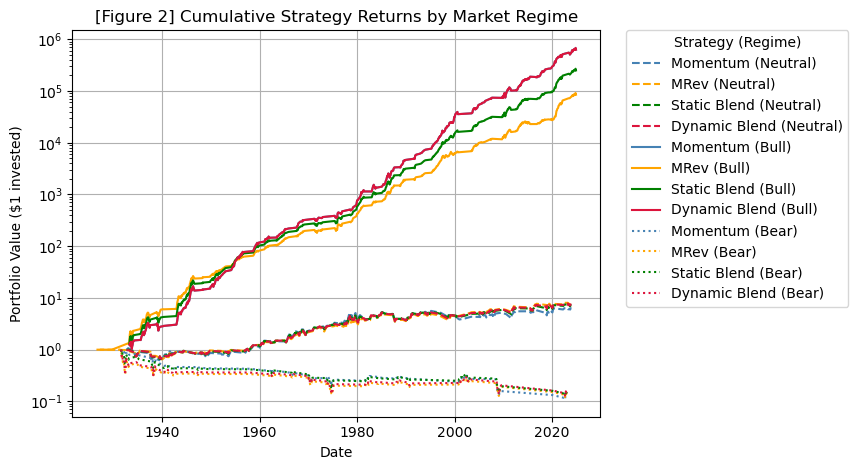

In [35]:
#| label:Figure_2


plt.figure()
for regime, (cum_mom, cum_mrev, cum_static, cum_dynamic) in cumulative_by_regime.items():
    linestyle = style_map.get(regime, "solid")
    plt.plot(cum_mom.index.to_timestamp(), cum_mom, label=f"Momentum ({regime})", linestyle=linestyle, color=color_map["Momentum"])
    plt.plot(cum_mrev.index.to_timestamp(), cum_mrev, label=f"MRev ({regime})", linestyle=linestyle, color=color_map["MRev"])
    plt.plot(cum_static.index.to_timestamp(), cum_static, label=f"Static Blend ({regime})", linestyle=linestyle, color=color_map["Static"])
    plt.plot(cum_dynamic.index.to_timestamp(), cum_dynamic, label=f"Dynamic Blend ({regime})", linestyle=linestyle, color=color_map["Dynamic"])

plt.title("[Figure 2] Cumulative Strategy Returns by Market Regime")
plt.ylabel("Portfolio Value ($1 invested)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.semilogy()

# Place legend outside the plot on the right
plt.legend(
    bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
    title="Strategy (Regime)", ncol=1
)

plt.show()

In [36]:
# print("Regime counts after alignment:")
# print(combined_df["Regime"].value_counts())

# print("\nStrategy return start date:", combined_df.index.min())
# print("Regime range:", regimes.index.min(), "to", regimes.index.max())

# # Optional: Show actual rolling market returns around Bear/Neutral dates
# print("\nRolling Market Return examples:")
# print(rolling_market_return.head(20))

In [37]:
## Industry Analysis over Market Regimes

In [38]:
# === Parameters ===
lookback = 12
skip_months = 1
long_n = 10
short_n = 10
target_long = 1.0
target_short = 1.0

# === Get Bull Market Months ===
bull_months = regimes[regimes == "Bull"].index

# === Rebuild Momentum Strategy Weights ===
weights_mom = pd.DataFrame(0.0, index=ind49.index, columns=ind49.columns)

for i in range(lookback + skip_months, len(ind49)):
    date = ind49.index[i]
    past_window = ind49.iloc[i - lookback - skip_months : i - skip_months]
    if past_window.isnull().any().any():
        continue

    signal = (1 + past_window).prod() - 1
    long_inds = signal.sort_values(ascending=False).head(long_n).index
    short_inds = signal.sort_values().head(short_n).index

    weights = pd.Series(0.0, index=ind49.columns)
    weights[long_inds] = 1 / long_n
    weights[short_inds] = -1 / short_n

    long_total = weights[weights > 0].sum()
    short_total = -weights[weights < 0].sum()

    if long_total > 0:
        weights[weights > 0] *= target_long / long_total
    if short_total > 0:
        weights[weights < 0] *= target_short / short_total

    weights_mom.loc[date] = weights

# === Filter weights in Bull Market Months ===
bull_weights = weights_mom.loc[weights_mom.index.intersection(bull_months)]

# === Compute Average Returns in Bull Markets ===
bull_returns = ind49.loc[ind49.index.intersection(bull_months)]
avg_bull_weight = bull_weights.mean()
avg_bull_returns = bull_returns.mean()
expected_returns = avg_bull_weight * avg_bull_returns

# === Get only top/bottom weighted industries ===
top_mom = avg_bull_weight.sort_values(ascending=False).head(10)
bottom_mom = avg_bull_weight.sort_values().head(10)

# === Build DataFrame with both Weight & Return ===
analysis_df = pd.DataFrame({
    "Avg Momentum Weight": avg_bull_weight,
    "Avg Bull Market Return": avg_bull_returns,
    "Expected Return (w*r)": expected_returns
})

top_df = analysis_df.loc[top_mom.index]
bottom_df = analysis_df.loc[bottom_mom.index]

# # === Print Results ===
# print("=== Top 10 Weighted Industries ===")
# print(top_df.round(4).to_string())

# print("\n=== Bottom 10 Weighted Industries ===")
# print(bottom_df.round(4).to_string())

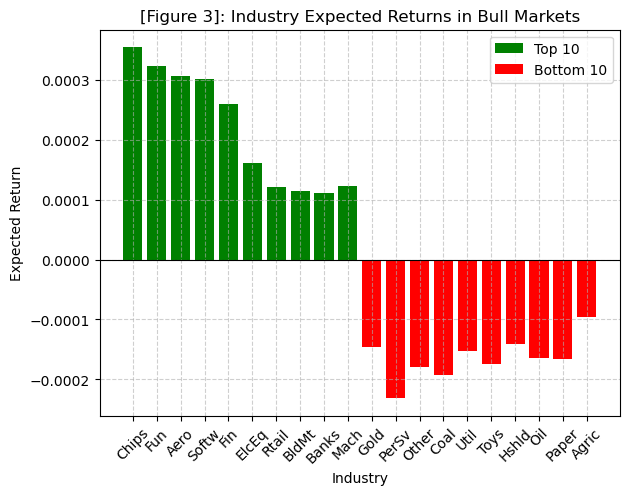

In [39]:
#| label:Figure_3

plt.figure()
plt.bar(top_df.index, top_df["Expected Return (w*r)"], label="Top 10", color='green')
plt.bar(bottom_df.index, bottom_df["Expected Return (w*r)"], label="Bottom 10", color='red')
plt.axhline(0, color='black', linewidth=0.8)
plt.title("[Figure 3]: Industry Expected Returns in Bull Markets")
plt.ylabel("Expected Return")
plt.xlabel("Industry")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [40]:
# === Parameters ===
lookback = 60
trim_amount = 0.05
max_reallocation = 0.3
top_percentile = 90
bottom_percentile = 20

# === Get Bear Market Months ===
bear_months = regimes[regimes == "Bear"].index

# === Rebuild Mean Reversion Strategy Weights ===
weights_mrev = pd.DataFrame(0.0, index=ind49.index, columns=ind49.columns)
rolling_5y_total = (1 + ind49).rolling(lookback).apply(np.prod, raw=True) - 1

# Signal Generation
signals_mrev = pd.DataFrame(0, index=rolling_5y_total.index, columns=ind49.columns)
for date in rolling_5y_total.index[lookback:]:
    row = rolling_5y_total.loc[date]
    if row.isnull().all():
        continue
    top = np.nanpercentile(row, top_percentile)
    bottom = np.nanpercentile(row, bottom_percentile)
    signals_mrev.loc[date] = np.where(row > top, -1, np.where(row < bottom, 1, 0))

# Initialize Weights
n_industries = ind49.shape[1]
weights_mrev.iloc[lookback - 1] = 1 / n_industries

# Rebalancing Loop
for i in range(lookback, len(ind49)):
    prev = weights_mrev.iloc[i - 1].copy()
    signal = signals_mrev.iloc[i]
    updated = prev.copy()

    overvalued = signal[signal == -1].index
    undervalued = signal[signal == 1].index

    realloc = 0
    for industry in overvalued:
        reduction = min(updated[industry], trim_amount)
        updated[industry] -= reduction
        realloc += reduction
    realloc = min(realloc, max_reallocation)

    if len(undervalued) > 0:
        scores = rolling_5y_total.iloc[i][undervalued].rank(ascending=True)
        inverse_ranks = 1 / scores
        total_score = inverse_ranks.sum()
        if total_score > 0:
            allocation = realloc * (inverse_ranks / total_score)
            for industry in undervalued:
                updated[industry] += allocation[industry]

    weights_mrev.iloc[i] = updated

# === Filter weights in Bear Market Months ===
bear_weights_mrev = weights_mrev.loc[weights_mrev.index.intersection(bear_months)]

# === Compute Average Returns in Bear Markets ===
bear_returns = ind49.loc[ind49.index.intersection(bear_months)]
avg_bear_weight = bear_weights_mrev.mean()
avg_bear_returns = bear_returns.mean()
expected_returns = avg_bear_weight * avg_bear_returns

# === Get only top/bottom weighted industries ===
top_mrev = avg_bear_weight.sort_values(ascending=False).head(10)
bottom_mrev = avg_bear_weight.sort_values().head(10)

# === Build DataFrame with both Weight & Return ===
analysis_df = pd.DataFrame({
    "Avg Mean Reversion Weight": avg_bear_weight,
    "Avg Bear Market Return": avg_bear_returns,
    "Expected Return (w*r)": expected_returns
})

top_df = analysis_df.loc[top_mrev.index]
bottom_df = analysis_df.loc[bottom_mrev.index]

# # === Print Results ===
# print("=== Top 10 Weighted Industries (Mean Reversion in Bear Market) ===")
# print(top_df.round(4).to_string())

# print("\n=== Bottom 10 Weighted Industries (Mean Reversion in Bear Market) ===")
# print(bottom_df.round(4).to_string())

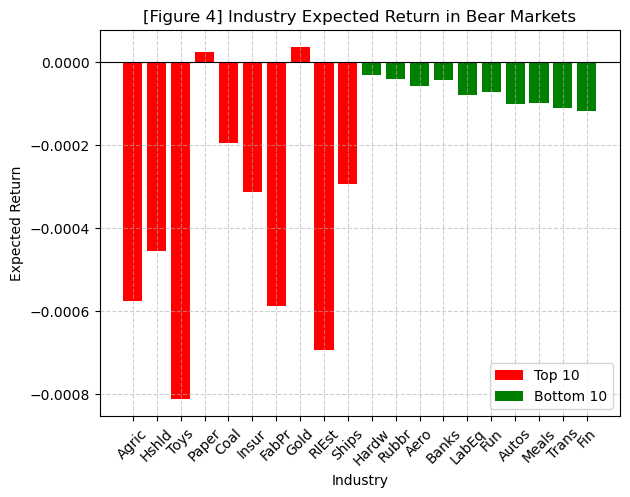

In [41]:
#| label:Figure_4


plt.figure()
plt.bar(top_df.index, top_df["Expected Return (w*r)"], label="Top 10", color='red')
plt.bar(bottom_df.index, bottom_df["Expected Return (w*r)"], label="Bottom 10", color='green')
plt.axhline(0, color='black', linewidth=0.8)
plt.title("[Figure 4] Industry Expected Return in Bear Markets")
plt.ylabel("Expected Return")
plt.xlabel("Industry")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [42]:
## Heatmap of Industry Trends over Time

In [43]:
os.environ["OMP_NUM_THREADS"] = "1"
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")
cohort_ranges = [(year, year + 9) for year in range(1926, 2025, 10)]
cluster_results = pd.DataFrame(index=ind49.columns)

for start, end in cohort_ranges:
    cohort_data = ind49.loc[f'{start}-01':f'{end}-12'].dropna(axis=1)
    
    if cohort_data.shape[1] < 4:
        continue

    features = pd.DataFrame({
        'mean_return': cohort_data.mean(),
        'volatility': cohort_data.std(),
    })

    scaled = StandardScaler().fit_transform(features)
    labels = KMeans(n_clusters=4, random_state=42, n_init='auto').fit_predict(scaled)
    cluster_results.loc[features.index, f'{start}-{end}'] = labels

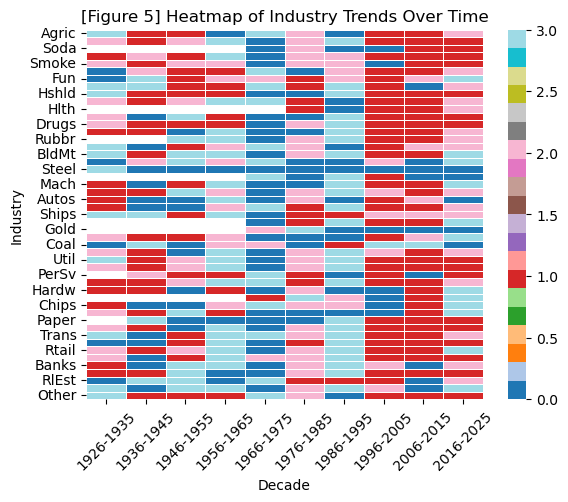

In [44]:
# | label:Figure_5


plt.figure()
sns.heatmap(cluster_results, cmap='tab20', linewidths=0.5, cbar=True)
plt.title("[Figure 5] Heatmap of Industry Trends Over Time")
plt.ylabel("Industry")
plt.xlabel("Decade")
plt.xticks(rotation=45)
plt.show()

In [45]:
## Strategy Regression Analysis

In [46]:
# === Ensure both use the same monthly period format (YYYY-MM) ===
common_index = excess_dynamic.index.intersection(ff5.index)

# === Trim both series to start from July 1963 ===
start_date = pd.Period("1963-07", freq='M')
excess_dynamic_trimmed = excess_dynamic[excess_dynamic.index >= start_date]
ff5_trimmed = ff5[ff5.index >= start_date]

# === Align exactly on index intersection ===
excess_dynamic_aligned = excess_dynamic_trimmed.loc[common_index]
ff5_aligned = ff5_trimmed.loc[common_index, ["Mkt-RF", "SMB", "HML", "RMW", "CMA"]]

# === Regression Setup ===
X = sm.add_constant(ff5_aligned)
Y = excess_dynamic_aligned

model = sm.OLS(Y, X)
results = model.fit()

# === Summary Output ===
print("Table 2: Regression Results")
print(results.summary())

predicted = results.predict(X)

Table 2: Regression Results
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     860.8
Date:                Thu, 22 May 2025   Prob (F-statistic):          1.15e-303
Time:                        21:08:32   Log-Likelihood:                 1830.4
No. Observations:                 738   AIC:                            -3649.
Df Residuals:                     732   BIC:                            -3621.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021   

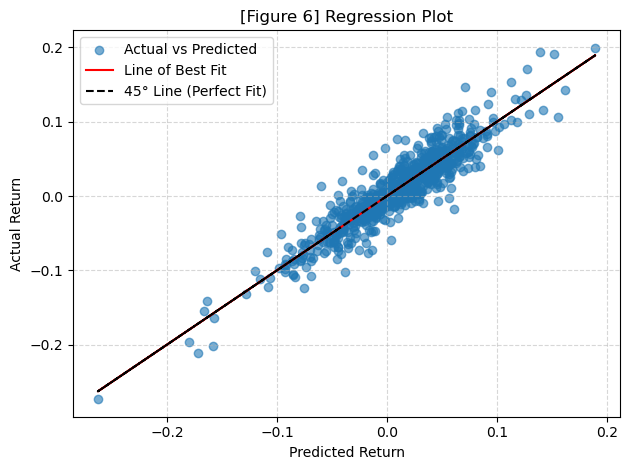

In [47]:
#| label:Figure_6


plt.figure()
plt.scatter(predicted, Y, alpha=0.6, label='Actual vs Predicted')
# Line of best fit (regression line)
fit_slope, fit_intercept = np.polyfit(predicted, Y, 1)
plt.plot(predicted, fit_slope * predicted + fit_intercept, color='red', label='Line of Best Fit')
plt.plot(predicted, predicted, color='black', linestyle='--', label='45° Line (Perfect Fit)')
plt.title("[Figure 6] Regression Plot")
plt.xlabel("Predicted Return")
plt.ylabel("Actual Return")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [48]:
# Preparing Data File

In [49]:
def write_csv(portfolio_returns, group_number):
    """
    Write portfolio returns to a CSV file named Group_XX.csv with Date as YYYY-MM.
    
    Parameters:
    - portfolio_returns: pandas Series or DataFrame with monthly returns (as decimals) and Date index
    - group_number: int, your two-digit group number (e.g., 1 for Group_01)
    
    Output:
    - Saves Group_XX.csv with two columns: Date (YYYY-MM) and Group_XX (returns as decimals)
    """
    
    # Make two-digit group number
    group_str = f"{group_number:02d}"
    filename = f"Group_{group_str}.csv"
    
    # Convert returns to DataFrame if Series
    if isinstance(portfolio_returns, pd.Series):
        df = portfolio_returns.to_frame(name=f"Group_{group_str}")
    else:
        df = portfolio_returns.rename(columns={portfolio_returns.columns[0]: f"Group_{group_str}"})
    
    # Convert index to PeriodIndex with monthly frequency and format as YYYY-MM
    if isinstance(df.index, pd.PeriodIndex):
        if df.index.freq != 'ME':
            df.index = df.index.to_timestamp().to_period('M')
    elif isinstance(df.index, pd.DatetimeIndex):
        df.index = df.index.to_period('M')
    else:
        raise ValueError("Index must be a datetime or PeriodIndex")
    
    # Rename index to Date
    df.index.name = "Date"
    
    # Write to CSV
    df.to_csv(filename, index=True)
    
    print(f"Saved portfolio returns to {filename}")

In [50]:
df_dynamic["Blended Dynamic"]  # This is your final strategy return stream

Date
1931-08    0.004590
1931-09   -0.258442
1931-10    0.069833
1931-11   -0.093644
1931-12   -0.152800
             ...   
2024-08   -0.024427
2024-09    0.026205
2024-10   -0.016685
2024-11    0.078533
2024-12   -0.074341
Freq: M, Name: Blended Dynamic, Length: 1121, dtype: float64

In [51]:
write_csv(df_dynamic["Blended Dynamic"], group_number=2)  # Replace with your actual group number

Saved portfolio returns to Group_02.csv


In [52]:
# # Example usage:
# dates = pd.date_range(start="1931-07-01", end="1936-06-01", freq="MS")
# returns = pd.Series([0.0025, 0.01, -0.005] + [0.001] * (len(dates) - 3), index=dates)
# write_csv(returns, 1)

In [53]:
group_02 = (
    pd.read_csv(
        filepath_or_buffer='Group_02.csv',
        parse_dates=['Date'],
        na_values=[-99.99, -999]
    )
    .assign(Date=lambda x: x['Date'].dt.to_period('M'))
    .set_index('Date')
    .rename_axis(columns=['Team'])
    .div(100)
)

In [54]:
group_02.head()

Team,Group_02
Date,
1931-08,0.000046
1931-09,-0.002584
1931-10,0.000698
1931-11,-0.000936
1931-12,-0.001528


In [55]:
## 